In [51]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [52]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [53]:
# Parameters
Δt = 0.01e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

I0 = 1e-14
Vt = 0.026
Rc = 7.5346
R1 = 1.0

n̂  = x̂ = [1.0, 0.0]
nothing

In [54]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [55]:
mutable struct ElectricDevice{D, T}
    ti :: Int
    it :: Int
    D0 :: Matrix{T}
    D1 :: Matrix{T}
    xp :: Vector{T}
    up :: Vector{T}
    x  :: Vector{T}
    u  :: Vector{T}
    y  :: Vector{T}
end

function ElectricDevice{D, T}(D0, D1) where {D, T}
    N, M = size(D0[:,:])
    device = ElectricDevice{D, T}(
        0, 0, zeros(T, N, M), zeros(T, N, M),
        zeros(T, N), zeros(T, M),
        zeros(T, N), zeros(T, M), zeros(T, M)
    )
    device.D0 .= D0
    device.D1 .= D1
    return device
end

import Base
function Base.copy(src :: ElectricDevice{D, T}) where {D, T}
    D0 = similar(src.D0)
    D1 = similar(src.D1)
    dst = ElectricDevice{D, T}(D0, D1)
    copy!(dst, src)
    return dst
end

function Base.copy!(dst :: ElectricDevice{D, T}, src :: ElectricDevice{D, T}) where {D, T}
    dst.D0 .= src.D0
    dst.D1 .= src.D1
    dst.xp .= src.xp
    dst.up .= src.up
    dst.x  .= src.x
    dst.u  .= src.u
    dst.y  .= src.y
    dst.it  = src.it
    dst.ti  = src.ti
    return dst
end

function natPreComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function forcedComm(state)
    if state.ti == 1 return 1 end
    if state.ti == 2 return 2 end
end

function natPostComm(state)
    u = state.u
    if state.ti == 1 return (u[1]  < -u[2]) ? 2 : 1 end
    if state.ti == 2 return (u[1]  >=-u[2]) ? 1 : 2 end
end

function update!(state)    
    if state.ti == 1 D = state.D0 end
    if state.ti == 2 D = state.D1 end
    state.y[:] .= D * state.u
end

function init!(state)
    state.ti = 1
    state.it = 0
end

function step!(state, excitation)
    state.u[1] = excitation
    state.u[2] = 0.026
    state.ti = natPreComm(state)
    state.ti = natPostComm(state)
    state.ti = forcedComm(state)
    update!(state)
    state.up .= state.u
    state.xp .= state.x
    return state.y[1]
end

step! (generic function with 1 method)

In [56]:
D1 = ElectricDevice{:D, Dual{Float64}}([0. 0.; -1. 0.], [-0.333 -0.333; -0.999 3.33e-16])
init!(D1);

In [57]:
w, h = .80, .02
n, m = 80, 2
lx = w / n
ly = h / m
el2ed, el2edd = quadmesh(w, h, n, m);

In [58]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_CIR  = 4
DOF_ABC  = 5
DOF_END  = 6

function dof_type(n, m)
    global NUM_EDGES
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
        if 1 <= i_edge <= n
            dof_flag[i_edge] = DOF_PEC
        end
        
        if 1 <= (NUM_EDGES - i_edge + 1) <= n
            dof_flag[i_edge] = DOF_PEC
        end
    end
    for i_edge =  n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_SRC
        println("$i_edge => SRC")
    end
    for i_edge = 2n+1:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_END
        println("$i_edge => END")
    end
    for i_edge =  n+1+40:(2n+1):NUM_EDGES
        dof_flag[i_edge] = DOF_CIR
        println("$i_edge => CIR")
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [59]:
DOF_CIR_D1 = 41
DOF_CIR_R1 = 42

dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
Γ[121] = DOF_CIR_D1
Γ[282] = DOF_CIR_R1
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

81 => SRC
242 => SRC
161 => END
322 => END
121 => CIR
282 => CIR


In [60]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

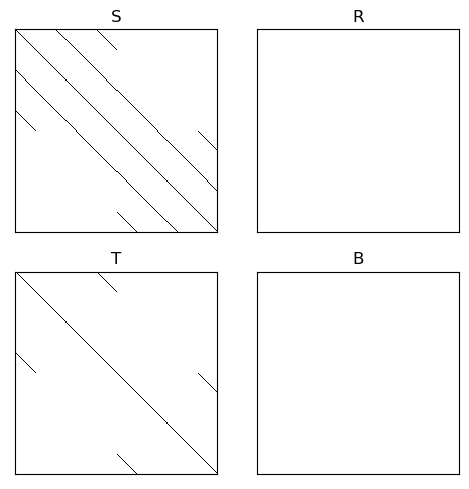

In [61]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [74]:
function voltage(t)
    10sin(2π*2e8*t)
end

function assemble_circuit!(i, didv, v, t)
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_CIR_R1
            i[jj] = v[jj] * 1.0 / R1
            didv[jj, jj] =  1.0 / R1
        end
        if Γ[ii] == DOF_CIR_D1
            y = step!(copy(D1), -v[jj] + Dual(0., 1.))
            i[jj], didv[jj, jj] = value(y), partials(y)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = v[jj] * 1.0 / Rc * 2.0 + voltage(t) / Rc
            didv[jj, jj] =  1.0 / Rc * 2.0
        end

        if Γ[ii] == DOF_END
            i[jj] = v[jj] * 1.0 / Rc * 2.0
            didv[jj, jj] =  1.0 / Rc * 2.0
        end
    end
end

assemble_circuit! (generic function with 1 method)

In [75]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [76]:
x = 0.010:0.050:0.510
y = 0.005:0.002:0.015
xx, yy = meshgrid(x, y);

it  = 1
nt  = 1600
t   = 0.00
i   = zeros(NUM_EDGES)
ip  = zeros(NUM_EDGES)
ipp = zeros(NUM_EDGES)
e   = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vol = zeros(nt)
cur = zeros(nt)

didv = spzeros(NUM_EDGES, NUM_EDGES)
nothing

In [77]:
N = 0
Δe = similar(e)

@elapsed for _ = it:nt
    b = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    #fill!(e,  0.0)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(i, didv, e, t)
        Fi = A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * ipp + b
        Ji = A   + 0.5Δt * ly^2 * μ0 * didv
        Δe .= Ji\Fi
        e .-= Δe
        #println("[nonlinear] |Δe| = $(norm(Δe))")
        N += 1
    end
    println("[linear] $it [nonlinear] converged in $N iterations with $(norm(Δe))")
    N = 0
    step!(D1, sum(e[dof[Γ .== DOF_CIR_D1]]) .+ Dual(0., 0.))
    epp .= ep
    ep  .= e

    ipp .= ip
    ip  .= i
    
    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vol[it] = sum(-e[dof[Γ .== DOF_CIR_D1]])
    cur[it] = sum( i[dof[Γ .== DOF_CIR_D1]])
    it += 1
    t  += Δt
end

[linear] 1 [nonlinear] converged in 1 iterations with 0.0
[linear] 2 [nonlinear] converged in 2 iterations with 1.0323009891856747e-18
[linear] 3 [nonlinear] converged in 2 iterations with 4.7026561422658445e-18
[linear] 4 [nonlinear] converged in 2 iterations with 3.2223011681670496e-17
[linear] 5 [nonlinear] converged in 2 iterations with 1.6154633701610236e-17
[linear] 6 [nonlinear] converged in 2 iterations with 1.832530913144162e-17
[linear] 7 [nonlinear] converged in 2 iterations with 3.240726682310425e-17
[linear] 8 [nonlinear] converged in 2 iterations with 5.093316626464963e-17
[linear] 9 [nonlinear] converged in 2 iterations with 7.815445977694265e-17
[linear] 10 [nonlinear] converged in 2 iterations with 6.786768349007217e-17
[linear] 11 [nonlinear] converged in 2 iterations with 1.0671290893009428e-16
[linear] 12 [nonlinear] converged in 2 iterations with 1.5483946680157578e-16
[linear] 13 [nonlinear] converged in 2 iterations with 5.857901536192292e-17
[linear] 14 [nonline

[linear] 134 [nonlinear] converged in 2 iterations with 3.2422203188608517e-15
[linear] 135 [nonlinear] converged in 2 iterations with 2.9076889075830445e-15
[linear] 136 [nonlinear] converged in 2 iterations with 3.766017322079431e-15
[linear] 137 [nonlinear] converged in 2 iterations with 3.582066569403372e-15
[linear] 138 [nonlinear] converged in 2 iterations with 3.810231626454961e-15
[linear] 139 [nonlinear] converged in 2 iterations with 3.594700536002558e-15
[linear] 140 [nonlinear] converged in 2 iterations with 3.695800855091145e-15
[linear] 141 [nonlinear] converged in 2 iterations with 3.3214487610936588e-15
[linear] 142 [nonlinear] converged in 2 iterations with 3.800995532199246e-15
[linear] 143 [nonlinear] converged in 2 iterations with 3.332079420667144e-15
[linear] 144 [nonlinear] converged in 2 iterations with 3.813578675764827e-15
[linear] 145 [nonlinear] converged in 2 iterations with 3.1540365952444693e-15
[linear] 146 [nonlinear] converged in 2 iterations with 3.80

[linear] 270 [nonlinear] converged in 2 iterations with 4.50356105318484e-15
[linear] 271 [nonlinear] converged in 2 iterations with 4.717479463053838e-15
[linear] 272 [nonlinear] converged in 2 iterations with 5.1336941493186325e-15
[linear] 273 [nonlinear] converged in 2 iterations with 4.843534083878886e-15
[linear] 274 [nonlinear] converged in 2 iterations with 3.769180128844065e-15
[linear] 275 [nonlinear] converged in 2 iterations with 4.3120324982894896e-15
[linear] 276 [nonlinear] converged in 2 iterations with 4.851100649507708e-15
[linear] 277 [nonlinear] converged in 2 iterations with 4.117032886476372e-15
[linear] 278 [nonlinear] converged in 2 iterations with 4.488131127569759e-15
[linear] 279 [nonlinear] converged in 2 iterations with 4.408257586305782e-15
[linear] 280 [nonlinear] converged in 2 iterations with 5.09789305623069e-15
[linear] 281 [nonlinear] converged in 2 iterations with 4.397716570141704e-15
[linear] 282 [nonlinear] converged in 2 iterations with 4.793292

[linear] 405 [nonlinear] converged in 10 iterations with 0.008177111921808401
[linear] 406 [nonlinear] converged in 10 iterations with 0.008118437832554382
[linear] 407 [nonlinear] converged in 10 iterations with 0.007816986031957563
[linear] 408 [nonlinear] converged in 10 iterations with 0.007478745249994411
[linear] 409 [nonlinear] converged in 10 iterations with 0.0072800083482298505
[linear] 410 [nonlinear] converged in 10 iterations with 0.007243970831846733
[linear] 411 [nonlinear] converged in 10 iterations with 0.007272673949584019
[linear] 412 [nonlinear] converged in 10 iterations with 0.007272256557255935
[linear] 413 [nonlinear] converged in 10 iterations with 0.007239552651511993
[linear] 414 [nonlinear] converged in 10 iterations with 0.007238800330682845
[linear] 415 [nonlinear] converged in 10 iterations with 0.007311918718665836
[linear] 416 [nonlinear] converged in 10 iterations with 0.007421434008940633
[linear] 417 [nonlinear] converged in 10 iterations with 0.0074

[linear] 535 [nonlinear] converged in 10 iterations with 0.0023271977651294217
[linear] 536 [nonlinear] converged in 10 iterations with 0.0024151348013492515
[linear] 537 [nonlinear] converged in 10 iterations with 0.002514389964704806
[linear] 538 [nonlinear] converged in 10 iterations with 0.0026265618093401226
[linear] 539 [nonlinear] converged in 10 iterations with 0.002740580278159911
[linear] 540 [nonlinear] converged in 10 iterations with 0.0028398906581669848
[linear] 541 [nonlinear] converged in 10 iterations with 0.002916656856016784
[linear] 542 [nonlinear] converged in 10 iterations with 0.0029797476125597894
[linear] 543 [nonlinear] converged in 10 iterations with 0.0030483084400164625
[linear] 544 [nonlinear] converged in 10 iterations with 0.003136114408599818
[linear] 545 [nonlinear] converged in 10 iterations with 0.0032408118728398092
[linear] 546 [nonlinear] converged in 10 iterations with 0.003347798423612076
[linear] 547 [nonlinear] converged in 10 iterations with 

[linear] 744 [nonlinear] converged in 2 iterations with 4.2072731744143825e-15
[linear] 745 [nonlinear] converged in 2 iterations with 4.6196662061377254e-15
[linear] 746 [nonlinear] converged in 2 iterations with 4.677234517096405e-15
[linear] 747 [nonlinear] converged in 2 iterations with 3.670335503334283e-15
[linear] 748 [nonlinear] converged in 2 iterations with 3.805856883080965e-15
[linear] 749 [nonlinear] converged in 2 iterations with 3.654425579237585e-15
[linear] 750 [nonlinear] converged in 2 iterations with 4.491315449728382e-15
[linear] 751 [nonlinear] converged in 2 iterations with 4.043881801324735e-15
[linear] 752 [nonlinear] converged in 2 iterations with 5.461987063660049e-15
[linear] 753 [nonlinear] converged in 2 iterations with 4.17303843716493e-15
[linear] 754 [nonlinear] converged in 2 iterations with 4.200183601294523e-15
[linear] 755 [nonlinear] converged in 2 iterations with 4.832769775993516e-15
[linear] 756 [nonlinear] converged in 2 iterations with 4.57197

[linear] 876 [nonlinear] converged in 2 iterations with 4.3789490283801965e-15
[linear] 877 [nonlinear] converged in 2 iterations with 4.804222755094067e-15
[linear] 878 [nonlinear] converged in 2 iterations with 4.121337220245277e-15
[linear] 879 [nonlinear] converged in 2 iterations with 4.8685779178274e-15
[linear] 880 [nonlinear] converged in 2 iterations with 4.966673244193235e-15
[linear] 881 [nonlinear] converged in 2 iterations with 4.506494654352754e-15
[linear] 882 [nonlinear] converged in 2 iterations with 5.019621868185199e-15
[linear] 883 [nonlinear] converged in 2 iterations with 4.749748210465509e-15
[linear] 884 [nonlinear] converged in 2 iterations with 4.513814198498533e-15
[linear] 885 [nonlinear] converged in 2 iterations with 4.4628615715885345e-15
[linear] 886 [nonlinear] converged in 2 iterations with 4.427528244678547e-15
[linear] 887 [nonlinear] converged in 2 iterations with 4.544781837725225e-15
[linear] 888 [nonlinear] converged in 2 iterations with 4.879727

[linear] 1022 [nonlinear] converged in 10 iterations with 0.0011645556256480018
[linear] 1023 [nonlinear] converged in 10 iterations with 0.001243934842190399
[linear] 1024 [nonlinear] converged in 10 iterations with 0.0013165609954287785
[linear] 1025 [nonlinear] converged in 10 iterations with 0.001382662678808675
[linear] 1026 [nonlinear] converged in 10 iterations with 0.0014433214817553433
[linear] 1027 [nonlinear] converged in 10 iterations with 0.0015077911078030246
[linear] 1028 [nonlinear] converged in 10 iterations with 0.0015916626366192066
[linear] 1029 [nonlinear] converged in 10 iterations with 0.0017060056304283268
[linear] 1030 [nonlinear] converged in 10 iterations with 0.00184690191926349
[linear] 1031 [nonlinear] converged in 10 iterations with 0.0019952201229554304
[linear] 1032 [nonlinear] converged in 10 iterations with 0.0021277189814898102
[linear] 1033 [nonlinear] converged in 10 iterations with 0.0022308140915587417
[linear] 1034 [nonlinear] converged in 10 it

[linear] 1199 [nonlinear] converged in 2 iterations with 4.680272826674093e-15
[linear] 1200 [nonlinear] converged in 2 iterations with 5.1289838426096506e-15
[linear] 1201 [nonlinear] converged in 2 iterations with 4.73531246514043e-15
[linear] 1202 [nonlinear] converged in 2 iterations with 4.851627578469657e-15
[linear] 1203 [nonlinear] converged in 2 iterations with 4.177516569054011e-15
[linear] 1204 [nonlinear] converged in 2 iterations with 4.478755884153679e-15
[linear] 1205 [nonlinear] converged in 2 iterations with 4.490676800588404e-15
[linear] 1206 [nonlinear] converged in 2 iterations with 4.924029177577593e-15
[linear] 1207 [nonlinear] converged in 2 iterations with 5.1448412039333496e-15
[linear] 1208 [nonlinear] converged in 2 iterations with 3.8628499068920175e-15
[linear] 1209 [nonlinear] converged in 2 iterations with 5.001367954074991e-15
[linear] 1210 [nonlinear] converged in 2 iterations with 4.772428510585328e-15
[linear] 1211 [nonlinear] converged in 2 iteration

[linear] 1329 [nonlinear] converged in 2 iterations with 5.006792400010048e-15
[linear] 1330 [nonlinear] converged in 2 iterations with 4.220583551728991e-15
[linear] 1331 [nonlinear] converged in 2 iterations with 5.066140083004049e-15
[linear] 1332 [nonlinear] converged in 2 iterations with 4.684451761907599e-15
[linear] 1333 [nonlinear] converged in 2 iterations with 5.4785902992928025e-15
[linear] 1334 [nonlinear] converged in 2 iterations with 4.414516717491965e-15
[linear] 1335 [nonlinear] converged in 2 iterations with 5.239604845443088e-15
[linear] 1336 [nonlinear] converged in 2 iterations with 4.492040968917641e-15
[linear] 1337 [nonlinear] converged in 2 iterations with 4.3785185356143825e-15
[linear] 1338 [nonlinear] converged in 2 iterations with 4.700339120993596e-15
[linear] 1339 [nonlinear] converged in 2 iterations with 5.349023630967366e-15
[linear] 1340 [nonlinear] converged in 2 iterations with 4.871771128161129e-15
[linear] 1341 [nonlinear] converged in 2 iteration

[linear] 1465 [nonlinear] converged in 10 iterations with 0.004218126713943351
[linear] 1466 [nonlinear] converged in 10 iterations with 0.004153595733185195
[linear] 1467 [nonlinear] converged in 10 iterations with 0.004087578474678617
[linear] 1468 [nonlinear] converged in 10 iterations with 0.004032403264656259
[linear] 1469 [nonlinear] converged in 10 iterations with 0.003992750923037824
[linear] 1470 [nonlinear] converged in 10 iterations with 0.003951018954479642
[linear] 1471 [nonlinear] converged in 10 iterations with 0.003875230783262528
[linear] 1472 [nonlinear] converged in 10 iterations with 0.003745421293096434
[linear] 1473 [nonlinear] converged in 10 iterations with 0.003575335298173308
[linear] 1474 [nonlinear] converged in 10 iterations with 0.0034080808051203536
[linear] 1475 [nonlinear] converged in 10 iterations with 0.003286625969180065
[linear] 1476 [nonlinear] converged in 10 iterations with 0.0032229221117352834
[linear] 1477 [nonlinear] converged in 10 iteratio

[linear] 1599 [nonlinear] converged in 10 iterations with 0.007067686365394578
[linear] 1600 [nonlinear] converged in 10 iterations with 0.007068177044423964


2.237325084

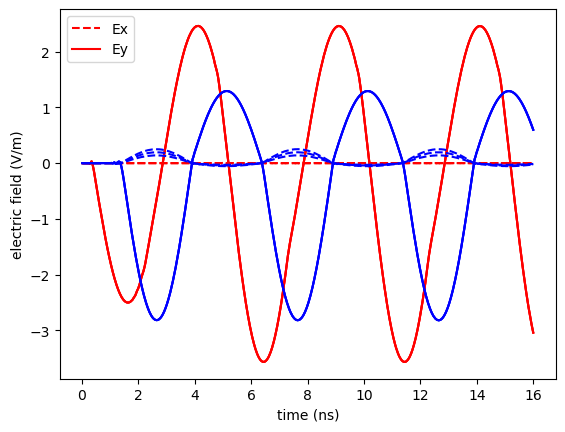

PyObject <matplotlib.legend.Legend object at 0x7ff8e9c026a0>

In [78]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 1], "r--", ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 2, 1], "r--", ts, res[:, 3, 2, 2], "r-")
plot(ts, res[:, 3, 3, 1], "r--", ts, res[:, 3, 3, 2], "r-")
plot(ts, res[:, 9, 1, 1], "b--", ts, res[:, 9, 1, 2], "b-")
plot(ts, res[:, 9, 2, 1], "b--", ts, res[:, 9, 2, 2], "b-")
plot(ts, res[:, 9, 3, 1], "b--", ts, res[:, 9, 3, 2], "b-")
xlabel("time (ns)")
ylabel("electric field (V/m)")
legend(["Ex", "Ey"])


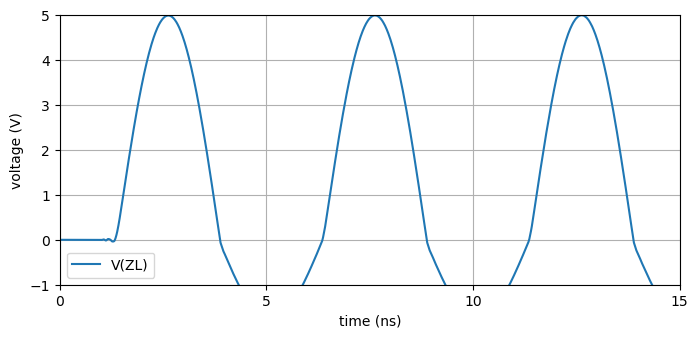

In [79]:
ts = 1e9Δt * collect(1:nt)
figure(figsize=(8, 3.5))
grid()
plot(ts, vol)
xlabel("time (ns)")
ylabel("voltage (V)")
legend(["V(ZL)"])
xticks(0:5:15), xlim((0, 15))
yticks(-1:5),   ylim((-1, 5))
nothing

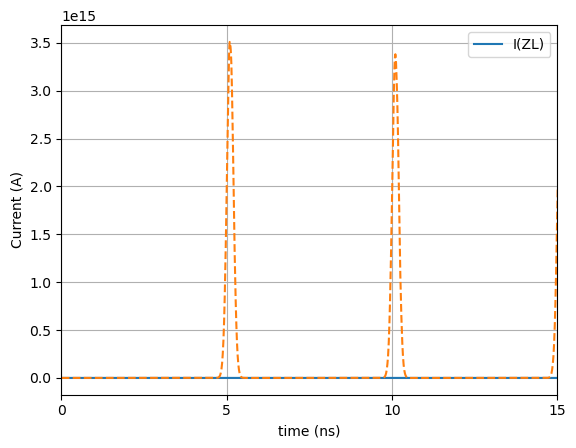

In [80]:
ts = 1e9Δt * collect(1:nt)
id = @. I0 * (exp(-vol/Vt) - 1.0)
grid()
plot(ts, cur)
plot(ts, id, "--")
xlabel("time (ns)")
ylabel("Current (A)")
legend(["I(ZL)"])
xticks(0:5:15), xlim((0, 15))
nothing